## Transfer Learning
*This notebook is for creating a model to predict the crop diseases using transfer learning*

Steps to build our model.

1.   Image Preprocessing
      * Convert to array

2.   Image Augmentation using Keras Image Data Generator
3.   Model Building
      * Use Transfer Learning models like VGG16, Xception, MobileVNet, etc. as a feature extractor then fit the traditional ML algorithms such as Random Forest Classifier, SVM, etc. to these extracted features

## Image Preprocessing

In [1]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator

In [2]:
def preprocess(image):
  img = cv2.GaussianBlur(image,(5,5),0)
  return img_to_array(img)

## Image Augmentation

In [3]:
# VARIABLES

TARGET_SIZE = (224, 224)
BATCH_SIZE = 50
EPOCHS = 40

LEARNING_RATE = 1e-4

In [4]:
train_path = '/content/drive/MyDrive/Omdena/Osun Nigeria/Data/Maize Images/data/train'
test_path = '/content/drive/MyDrive/Omdena/Osun Nigeria/Data/Maize Images/data/test'

In [5]:
train_generator = ImageDataGenerator(rescale=1.0/255,
                             rotation_range=30,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             zoom_range=0.2,
                             shear_range=0.3,
                             horizontal_flip=True,
                             brightness_range=[0.2, 0.8],
                             validation_split=0.2,
                             preprocessing_function=preprocess)

valid_generator = ImageDataGenerator(rescale=1./255,
                                     validation_split = 0.2,
                                   preprocessing_function=preprocess)

test_generator = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=preprocess)

In [6]:
def augment_images(datagen, directory, batch_size, target_size, subset=None):
  augmented_imgs = datagen.flow_from_directory(directory = directory,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    subset = subset)
  return augmented_imgs

In [7]:
train_aug = augment_images(train_generator, train_path, BATCH_SIZE, TARGET_SIZE, 'training')
valid_aug = augment_images(valid_generator, train_path, BATCH_SIZE, TARGET_SIZE, 'validation')
test_aug = augment_images(test_generator, test_path, BATCH_SIZE, TARGET_SIZE)

Found 2681 images belonging to 4 classes.
Found 667 images belonging to 4 classes.
Found 840 images belonging to 4 classes.


## Model Specification

In [8]:
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  
from tensorflow.keras.optimizers import Adam

In [ ]:
vgg_model = VGG16(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

In [ ]:
xception_model = Xception(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

In [11]:
def extract_features(pretrained_model, data):

  for layer in pretrained_model.layers:
    layer.trainable = False

  feature_extractor = pretrained_model.predict(data)
  features = feature_extractor.reshape(feature_extractor.shape[0], -1)

  return features

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

rf_train_features = extract_features(xception_model, train_aug)
rf_valid_features = extract_features(xception_model, valid_aug)
rf_test_features = extract_features(xception_model, test_aug)


In [14]:
rf_model.fit(rf_train_features, train_aug.classes)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [15]:
rf_pred = rf_model.predict(rf_test_features)

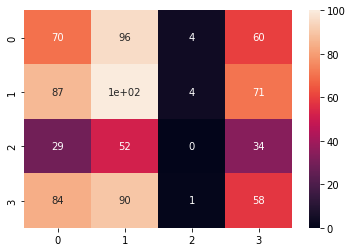

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

result = confusion_matrix(test_aug.classes, rf_pred)

sns.heatmap(result, annot=True)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test_aug.classes, rf_pred)

0.30238095238095236